In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Load the dataset
df = pd.read_csv(r'E:\internship\dataset for emotion\fer2013.csv')

X = []
y = []
for index, row in df.iterrows():
    pixels = row['pixels'].split(" ")
    pixels = np.array(pixels, dtype='float32')
    pixels = pixels.reshape(48, 48, 1)  # Reshape to (48, 48, 1) for grayscale
    pixels = np.repeat(pixels, 3, axis=-1)  # Convert to RGB by repeating the channel
    X.append(pixels)
    y.append(row['emotion'])

X = np.array(X)
y = np.array(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [2]:
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG19
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D

In [3]:
def create_vgg19(trainable_layers=15):
    base_vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(48, 48, 3))
    
    for layer in base_vgg19.layers[:-trainable_layers]:
        layer.trainable = False
    
    return base_vgg19

def Emotion_Model(input_shape=(48, 48, 3), trainable_layers=15):
    # Input layer
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    
    # Add the VGG19 model
    vgg19 = create_vgg19(trainable_layers=trainable_layers)
    vgg19_output = vgg19(visible)
    
    # Additional layers
    flatten = Flatten(name='flatten')(vgg19_output)
    dense1 = Dense(256, activation='relu', name='dense1')(flatten)
    batch_norm1 = BatchNormalization()(dense1)
    drop1 = Dropout(0.5)(batch_norm1)
    dense2 = Dense(128, activation='relu', name='dense2')(drop1)
    batch_norm2 = BatchNormalization()(dense2)
    drop2 = Dropout(0.5)(batch_norm2)
    
    # Output layer
    output = Dense(num_classes, activation='softmax', name='output')(drop2)

    # Create the model
    model = Model(inputs=visible, outputs=output)

    # Print model summary
    print(model.summary())

    return model


In [4]:
from tensorflow.keras.optimizers import Adam

# Create the FER model with VGG19
model = Emotion_Model(input_shape=(48, 48, 3), trainable_layers=21)  # Adjust the number of trainable layers as needed
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense1 (Dense)              (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

In [6]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Train the model
batch_size = 32
epochs = 100
model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
          steps_per_epoch=len(X_train) // batch_size, 
          epochs=epochs,
          validation_data=(X_test, y_test))

Epoch 1/100
897/897 [==============================] - 55s 60ms/step - loss: 2.0096 - accuracy: 0.3057 - val_loss: 2.8564 - val_accuracy: 0.2831
Epoch 2/100
897/897 [==============================] - 54s 60ms/step - loss: 1.7340 - accuracy: 0.3607 - val_loss: 16.2604 - val_accuracy: 0.1819
Epoch 3/100
897/897 [==============================] - 54s 60ms/step - loss: 1.6010 - accuracy: 0.3855 - val_loss: 1.4226 - val_accuracy: 0.4195
Epoch 4/100
897/897 [==============================] - 54s 60ms/step - loss: 1.5344 - accuracy: 0.4026 - val_loss: 1.9651 - val_accuracy: 0.3300
Epoch 5/100
897/897 [==============================] - 53s 59ms/step - loss: 1.4894 - accuracy: 0.4110 - val_loss: 3.1583 - val_accuracy: 0.3281
Epoch 6/100
897/897 [==============================] - 54s 60ms/step - loss: 1.4596 - accuracy: 0.4159 - val_loss: 1.4403 - val_accuracy: 0.3731
Epoch 7/100
897/897 [==============================] - 54s 61ms/step - loss: 1.4276 - accuracy: 0.4308 - val_loss: 1.4626 - val_a

225/225 [==============================] - 4s 17ms/step
              precision    recall  f1-score   support

       Angry       0.59      0.61      0.60       985
     Disgust       0.88      0.67      0.76       102
        Fear       0.58      0.53      0.55      1043
       Happy       0.88      0.83      0.85      1765
         Sad       0.47      0.65      0.55      1210
    Surprise       0.87      0.67      0.76       795
     Neutral       0.64      0.59      0.61      1278

    accuracy                           0.66      7178
   macro avg       0.70      0.65      0.67      7178
weighted avg       0.68      0.66      0.67      7178



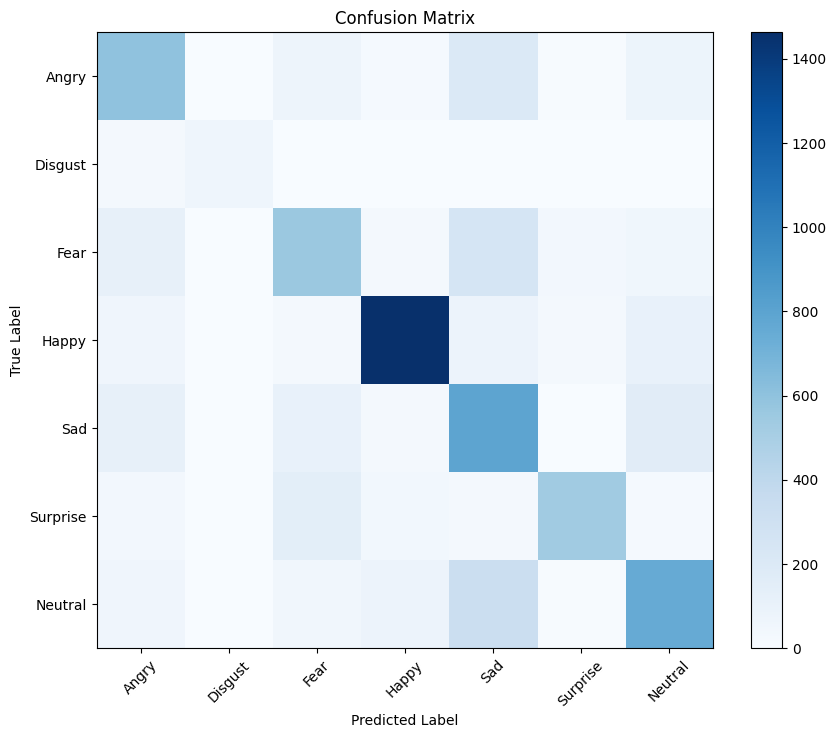

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on the test data
y_pred = model.predict(X_test)  # Assuming X_test is your test data
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to integer labels
true_classes = np.argmax(y_test, axis=1)

# Generate the classification report
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
classification_rep = classification_report(true_classes, y_pred_classes, target_names=class_labels)
print(classification_rep)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Display confusion matrix with labels
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [8]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(r"C:\Users\Govind\Inernship\Face emotion detection\models\modelpre.h5")
print("Saved model to disk")

Saved model to disk


In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing import image
model = model_from_json(open(r'C:\Users\Govind\Inernship\Face emotion detection\model.json').read())
model.load_weights(r"C:\Users\Govind\Inernship\Face emotion detection\models\modelpre.h5")

face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
cap=cv2.VideoCapture(0)

while cap.isOpened():
    res,frame=cap.read()

    height, width , channel = frame.shape
    sub_img = frame[0:int(height/6),0:int(width)]

    black_rect = np.ones(sub_img.shape, dtype=np.uint8)*0
    res = cv2.addWeighted(sub_img, 0.77, black_rect,0.23, 0)
    FONT = cv2.FONT_HERSHEY_SIMPLEX
    FONT_SCALE = 0.9
    FONT_THICKNESS = 4
    lable_color = (15, 10, 255)
    lable = "Emotion Detection"
    lable_dimension = cv2.getTextSize(lable,FONT ,FONT_SCALE,FONT_THICKNESS)[0]
    textX = int((res.shape[1] - lable_dimension[0]) / 2)
    textY = int((res.shape[0] + lable_dimension[1]) / 2)
    cv2.putText(res, lable, (textX,textY), FONT, FONT_SCALE, (0,0,0), FONT_THICKNESS)
    gray_image= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_haar_cascade.detectMultiScale(gray_image )
    try:
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, pt1=(x, y), pt2=(x + w, y + h), color=(255, 0, 0), thickness=2)
            roi_gray = gray_image[y - 5:y + h + 5, x - 5:x + w + 5]
            roi_gray_resized = cv2.resize(roi_gray, (48, 48))
            
            # Convert grayscale to RGB
            roi_rgb = cv2.cvtColor(roi_gray_resized, cv2.COLOR_GRAY2RGB)
            
            image_pixels = img_to_array(roi_rgb)  # Convert to image array
            image_pixels = np.expand_dims(image_pixels, axis=0)
            image_pixels /= 255
            predictions = model.predict(image_pixels)
            max_index = np.argmax(predictions[0])
            emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
            emotion_prediction = emotion_detection[max_index]
            cv2.putText(frame, "Sentiment: {}".format(emotion_prediction), (x+10,y+20), FONT,0.7, lable_color,2)
            lable_violation = 'Confidence: {}'.format(str(np.round(np.max(predictions[0])*100,1))+ "%")
            violation_text_dimension = cv2.getTextSize(lable_violation,FONT,FONT_SCALE,FONT_THICKNESS )[0]
            violation_x_axis = int(res.shape[1]- violation_text_dimension[0])
            cv2.putText(frame, lable_violation, (x,y-1), FONT,0.7, lable_color,2)
    except:
        pass
    frame[0:int(height/6),0:int(width)] =res
    cv2.imshow('frame', frame)


    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows

1/1 [==============================] - 0s 25ms/step


<function destroyAllWindows>

1/1 [==============================] - 0s 21ms/step


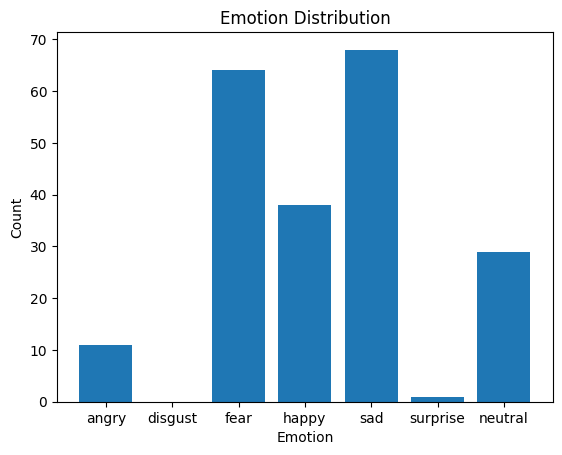

In [11]:
import os
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image

# Load the emotion detection model
model = model_from_json(open(r'C:\Users\Govind\Inernship\Face emotion detection\model.json').read())
model.load_weights(r"C:\Users\Govind\Inernship\Face emotion detection\models\modelpre.h5")

# Load the Haar Cascade for face detection
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Open the webcam
cap = cv2.VideoCapture(0)

# Get webcam resolution
webcam_width = int(cap.get(3))
webcam_height = int(cap.get(4))

# Create empty dictionaries to store emotion data
emotion_data = {emotion: 0 for emotion in ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')}

# Define text rendering properties
FONT = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
FONT_THICKNESS = 2
lable_color = (15, 10, 255)

# Function to capture and process emotions from webcam
def process_emotions(image_duration):
    start_time = time.time()
    while True:
        res, frame = cap.read()
        gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_haar_cascade.detectMultiScale(gray_image)
        try:
            for (x, y, w, h) in faces:
                roi_gray = gray_image[y:y + h, x:x + w]
                roi_gray_resized = cv2.resize(roi_gray, (48, 48))
                
                # Convert grayscale to RGB
                roi_rgb = cv2.cvtColor(roi_gray_resized, cv2.COLOR_GRAY2RGB)
                
                image_pixels = img_to_array(roi_rgb)  # Convert to image array
                image_pixels = np.expand_dims(image_pixels, axis=0)
                image_pixels /= 255
                predictions = model.predict(image_pixels)
                max_index = np.argmax(predictions[0])
                emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
                emotion_prediction = emotion_detection[max_index]
                
                # Display the emotion prediction
                cv2.putText(frame, "Sentiment: {}".format(emotion_prediction), (x, y - 20), FONT, FONT_SCALE, lable_color, FONT_THICKNESS)
                
                # Update emotion data
                emotion_data[emotion_prediction] += 1
        except:
            pass
        
        cv2.imshow('frame', frame)
        
        if time.time() - start_time >= image_duration:
            break

# Replace 'path/to/your/image_folder' with the path to your image folder
image_folder = r"E:\internship\test image"

# Set the time duration for each image in seconds
image_durations = [5, 5, 5, 5, 5]  # Modify this list as needed

for image_path, image_duration in zip(image_files, image_durations):
    # Load the image
    img = cv2.imread(image_path)
    
    # Resize the image to match the webcam resolution
    img = cv2.resize(img, (webcam_width, webcam_height))
    
    cv2.imshow('Image', img)
    cv2.waitKey(image_duration * 1000)  # Convert seconds to milliseconds

    # Process emotions during and after displaying the image
    process_emotions(image_duration)
    
# Calculate and display the graphical representation of emotions
emotions = list(emotion_data.keys())
emotion_counts = list(emotion_data.values())
plt.bar(emotions, emotion_counts)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Distribution')
plt.show()

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 15s 15s/step


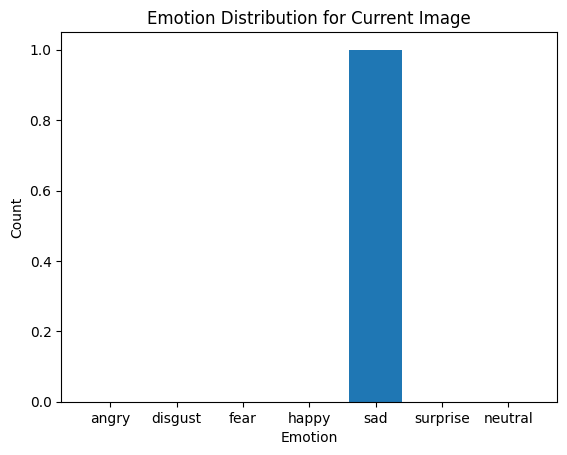

1/1 [==============================] - 0s 32ms/step


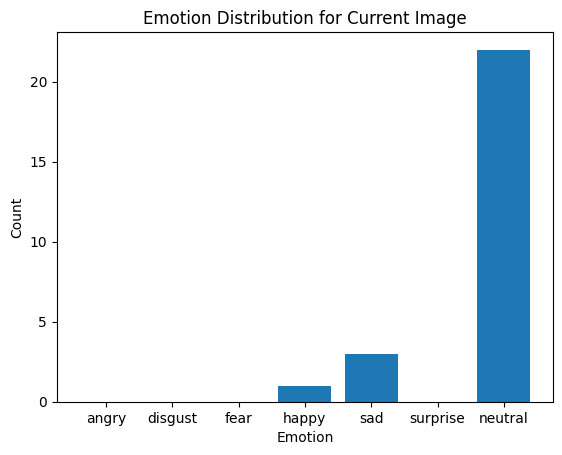

1/1 [==============================] - 0s 24ms/step


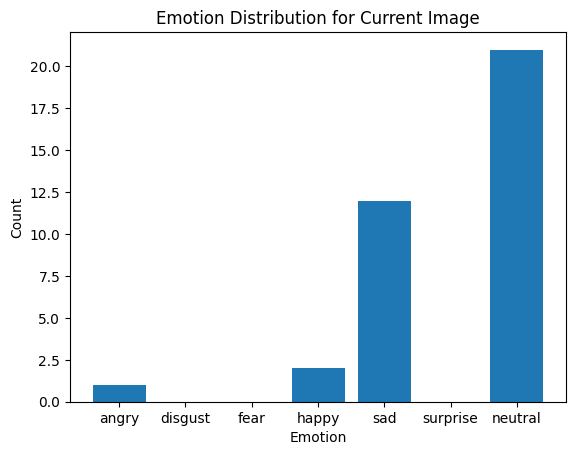

1/1 [==============================] - 0s 28ms/step


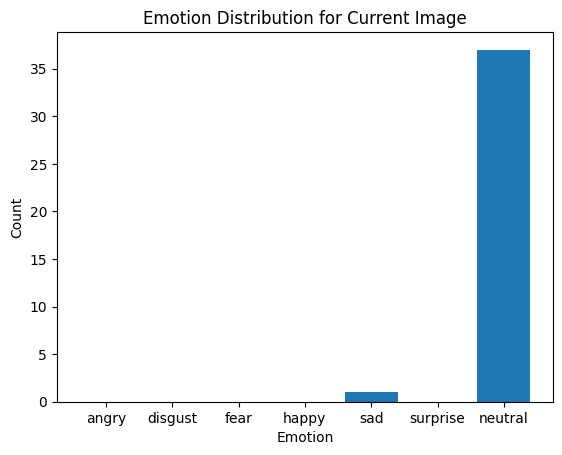

1/1 [==============================] - 0s 24ms/step


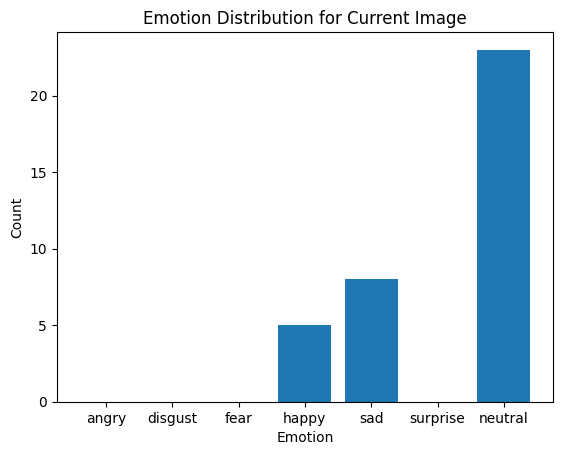

In [1]:
import os
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image

# Load the emotion detection model
model = model_from_json(open(r'C:\Users\Govind\Inernship\Face emotion detection\model.json').read())
model.load_weights(r"C:\Users\Govind\Inernship\Face emotion detection\models\modelpre.h5")

# Load the Haar Cascade for face detection
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Open the webcam
cap = cv2.VideoCapture(0)

# Get webcam resolution
webcam_width = int(cap.get(3))
webcam_height = int(cap.get(4))

# Define text rendering properties
FONT = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
FONT_THICKNESS = 2
lable_color = (15, 10, 255)

# Function to capture and process emotions from webcam
def process_emotions(image_duration):
    start_time = time.time()
    emotion_data = {emotion: 0 for emotion in ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')}
    
    while True:
        res, frame = cap.read()
        gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_haar_cascade.detectMultiScale(gray_image)
        try:
            for (x, y, w, h) in faces:
                roi_gray = gray_image[y:y + h, x:x + w]
                roi_gray_resized = cv2.resize(roi_gray, (48, 48))
                
                # Convert grayscale to RGB
                roi_rgb = cv2.cvtColor(roi_gray_resized, cv2.COLOR_GRAY2RGB)
                
                image_pixels = img_to_array(roi_rgb)  # Convert to image array
                image_pixels = np.expand_dims(image_pixels, axis=0)
                image_pixels /= 255
                predictions = model.predict(image_pixels)
                max_index = np.argmax(predictions[0])
                emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
                emotion_prediction = emotion_detection[max_index]
                
                # Display the emotion prediction
                cv2.putText(frame, "Sentiment: {}".format(emotion_prediction), (x, y - 20), FONT, FONT_SCALE, lable_color, FONT_THICKNESS)
                
                # Update emotion data
                emotion_data[emotion_prediction] += 1
        except:
            pass
        
        cv2.imshow('frame', frame)
        
        if time.time() - start_time >= image_duration:
            break

    # Calculate and display the graphical representation of emotions for the current image
    emotions = list(emotion_data.keys())
    emotion_counts = list(emotion_data.values())
    plt.bar(emotions, emotion_counts)
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.title('Emotion Distribution for Current Image')
    plt.show()

# Replace 'path/to/your/image_folder' with the path to your image folder
image_folder = r"E:\internship\test image"

# List image files in the specified folder
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Set the time duration for each image in seconds
image_durations = [5, 5, 5, 5, 5]  # Modify this list as needed

for image_path, image_duration in zip(image_files, image_durations):
    # Load the image
    img = cv2.imread(image_path)
    
    # Resize the image to match the webcam resolution
    img = cv2.resize(img, (webcam_width, webcam_height))
    
    cv2.imshow('Image', img)
    cv2.waitKey(image_duration * 1000)  # Convert seconds to milliseconds

    # Process emotions during and after displaying the image
    process_emotions(image_duration)
    
# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


In [1]:
import os
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image

# Load the emotion detection model
model = model_from_json(open(r'C:\Users\Govind\Inernship\Face emotion detection\model.json').read())
model.load_weights(r"C:\Users\Govind\Inernship\Face emotion detection\models\modelpre.h5")

# Load the Haar Cascade for face detection
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Open the webcam
cap = cv2.VideoCapture(0)

# Get webcam resolution
webcam_width = int(cap.get(3))
webcam_height = int(cap.get(4))

# Define text rendering properties
FONT = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
FONT_THICKNESS = 2
lable_color = (15, 10, 255)

# Function to capture and process emotions from webcam
def process_emotions(image_duration, image_name):
    start_time = time.time()
    emotion_data = {emotion: 0 for emotion in ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')}
    
    while True:
        res, frame = cap.read()
        gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_haar_cascade.detectMultiScale(gray_image)
        try:
            for (x, y, w, h) in faces:
                roi_gray = gray_image[y:y + h, x:x + w]
                roi_gray_resized = cv2.resize(roi_gray, (48, 48))
                
                # Convert grayscale to RGB
                roi_rgb = cv2.cvtColor(roi_gray_resized, cv2.COLOR_GRAY2RGB)
                
                image_pixels = img_to_array(roi_rgb)  # Convert to image array
                image_pixels = np.expand_dims(image_pixels, axis=0)
                image_pixels /= 255
                predictions = model.predict(image_pixels)
                max_index = np.argmax(predictions[0])
                emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
                emotion_prediction = emotion_detection[max_index]
                
                # Display the emotion prediction and image name
                cv2.putText(frame, "Sentiment: {}".format(emotion_prediction), (x, y - 20), FONT, FONT_SCALE, lable_color, FONT_THICKNESS)
                cv2.putText(frame, "Image Name: {}".format(image_name), (x, y - 50), FONT, FONT_SCALE, lable_color, FONT_THICKNESS)
                
                # Update emotion data
                emotion_data[emotion_prediction] += 1
        except:
            pass
        
        cv2.imshow('frame', frame)
        
        if time.time() - start_time >= image_duration:
            break

    return emotion_data

# Replace 'path/to/your/image_folder' with the path to your image folder
image_folder = r"E:\internship\test image"

# List image files in the specified folder
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Initialize variables to track emotion data for all images
all_emotion_data = {emotion: 0 for emotion in ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')}
image_emotion_data = {}

# Set the time duration for each image in seconds
image_durations = [5, 5, 5, 5, 5]  # Modify this list as needed

for image_path, image_duration in zip(image_files, image_durations):
    # Load the image
    img = cv2.imread(image_path)
    
    # Resize the image to match the webcam resolution
    img = cv2.resize(img, (webcam_width, webcam_height))
    
    cv2.imshow('Image', img)
    cv2.waitKey(image_duration * 1000)  # Convert seconds to milliseconds

    # Process emotions during displaying the image
    image_name = os.path.basename(image_path)
    image_emotion_data[image_name] = process_emotions(image_duration, image_name)
    
    # Update the overall emotion data
    all_emotion_data = Counter(all_emotion_data) + Counter(image_emotion_data[image_name])

# Calculate and display the most frequent emotion and its corresponding image name
most_frequent_emotion = max(all_emotion_data, key=all_emotion_data.get)
most_frequent_image_name = max(image_emotion_data, key=lambda k: image_emotion_data[k][most_frequent_emotion])
print("Most Frequent Emotion:", most_frequent_emotion)
print("Image Name with Most Frequent Emotion:", most_frequent_image_name)


# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 9s 9s/step


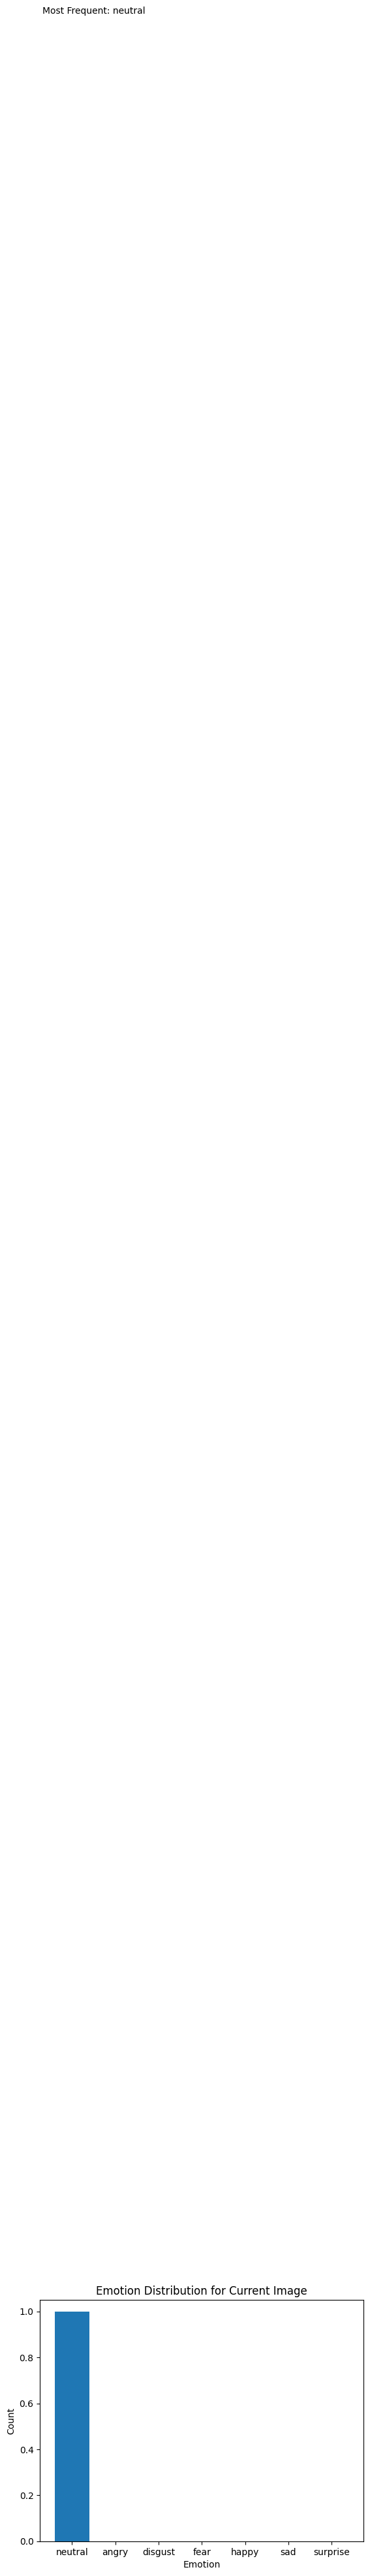

1/1 [==============================] - 0s 25ms/step


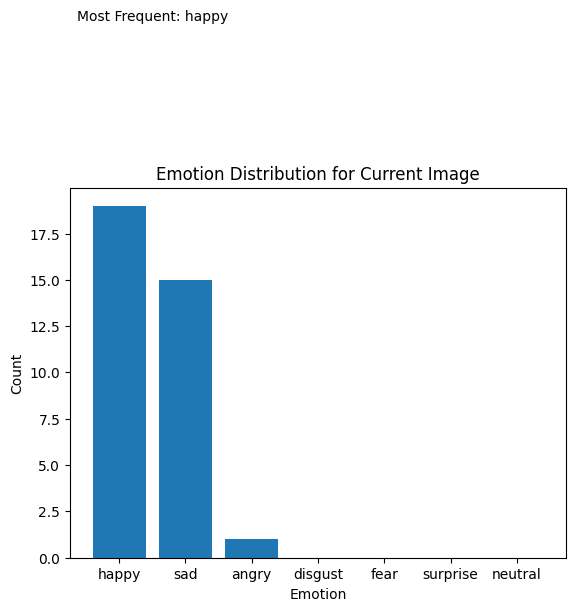

1/1 [==============================] - 0s 24ms/step


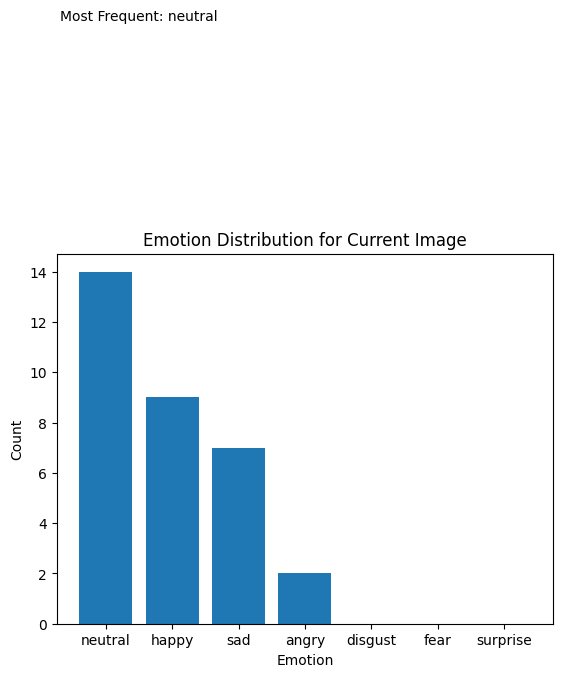

1/1 [==============================] - 0s 24ms/step


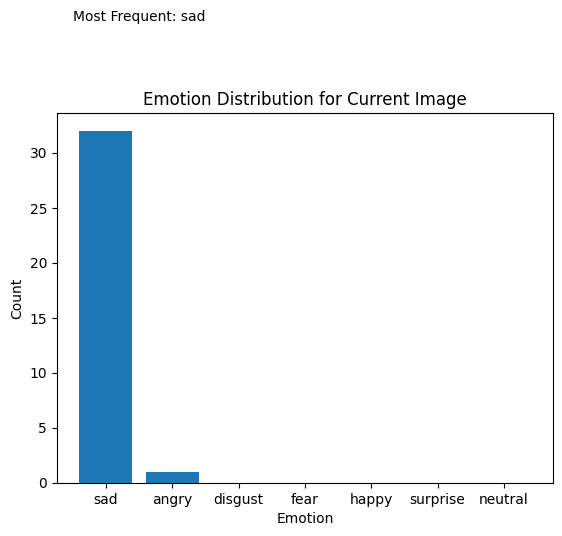

1/1 [==============================] - 0s 20ms/step


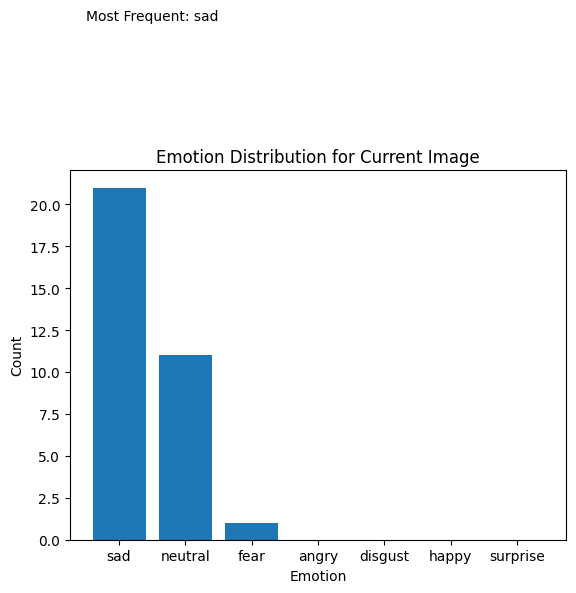

In [1]:
import os
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image

# Load the emotion detection model
model = model_from_json(open(r'C:\Users\Govind\Inernship\Face emotion detection\model.json').read())
model.load_weights(r"C:\Users\Govind\Inernship\Face emotion detection\models\modelpre.h5")

# Load the Haar Cascade for face detection
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Open the webcam
cap = cv2.VideoCapture(0)

# Get webcam resolution
webcam_width = int(cap.get(3))
webcam_height = int(cap.get(4))

# Define text rendering properties
FONT = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
FONT_THICKNESS = 2
label_color = (15, 10, 255)

# Function to capture and process emotions from webcam
def process_emotions(image_duration):
    start_time = time.time()
    emotion_data = {emotion: 0 for emotion in ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')}
    
    while True:
        res, frame = cap.read()
        gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_haar_cascade.detectMultiScale(gray_image)
        try:
            for (x, y, w, h) in faces:
                roi_gray = gray_image[y:y + h, x:x + w]
                roi_gray_resized = cv2.resize(roi_gray, (48, 48))
                
                # Convert grayscale to RGB
                roi_rgb = cv2.cvtColor(roi_gray_resized, cv2.COLOR_GRAY2RGB)
                
                image_pixels = img_to_array(roi_rgb)  # Convert to image array
                image_pixels = np.expand_dims(image_pixels, axis=0)
                image_pixels /= 255
                predictions = model.predict(image_pixels)
                max_index = np.argmax(predictions[0])
                emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
                emotion_prediction = emotion_detection[max_index]
                
                # Display the emotion prediction
                cv2.putText(frame, "Sentiment: {}".format(emotion_prediction), (x, y - 20), FONT, FONT_SCALE, label_color, FONT_THICKNESS)
                
                # Update emotion data
                emotion_data[emotion_prediction] += 1
        except:
            pass
        
        cv2.imshow('frame', frame)
        
        if time.time() - start_time >= image_duration:
            break

    # Find the most frequent emotion
    frequent_emotion = max(emotion_data, key=emotion_data.get)
    
    # Sort emotions by count, with the frequent emotion at the top
    emotions = sorted(emotion_data.keys(), key=lambda x: emotion_data[x], reverse=True)
    emotion_counts = [emotion_data[emotion] for emotion in emotions]
    
    # Plot the graph
    plt.bar(emotions, emotion_counts)
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.title('Emotion Distribution for Current Image')
    
    # Display the most frequent emotion at the top
    plt.text(0.5, max(emotion_counts) + 10, f'Most Frequent: {frequent_emotion}', ha='center')
    
    plt.show()

# Replace 'path/to/your/image_folder' with the path to your image folder
image_folder = r"E:\internship\test image"

# List image files in the specified folder
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Set the time duration for each image in seconds
image_durations = [5, 5, 5, 5, 5]  # Modify this list as needed

for image_path, image_duration in zip(image_files, image_durations):
    # Load the image
    img = cv2.imread(image_path)
    
    # Resize the image to match the webcam resolution
    img = cv2.resize(img, (webcam_width, webcam_height))
    
    cv2.imshow('Image', img)
    cv2.waitKey(image_duration * 1000)  # Convert seconds to milliseconds

    # Process emotions during and after displaying the image
    process_emotions(image_duration)
    
# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 28ms/step


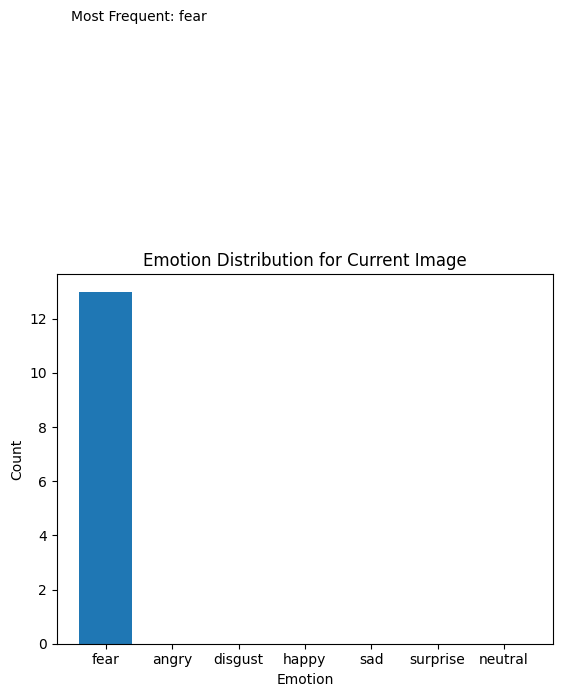

The person is not interested in the displayed image: E:\internship\test image\img1.jpg
1/1 [==============================] - 0s 24ms/step


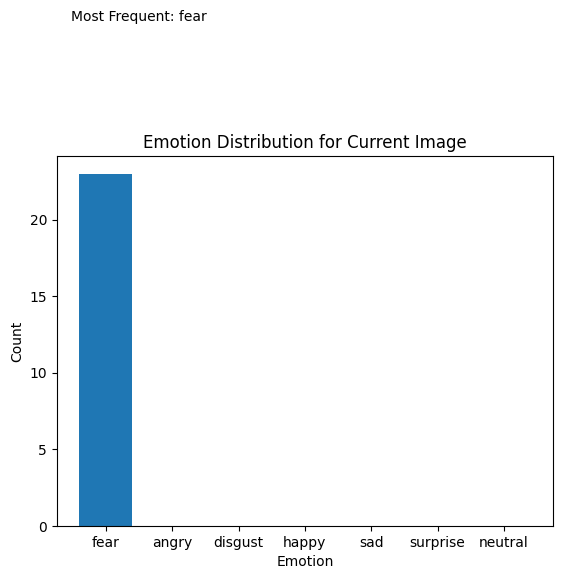

The person is not interested in the displayed image: E:\internship\test image\img2.jpg
1/1 [==============================] - 0s 20ms/step


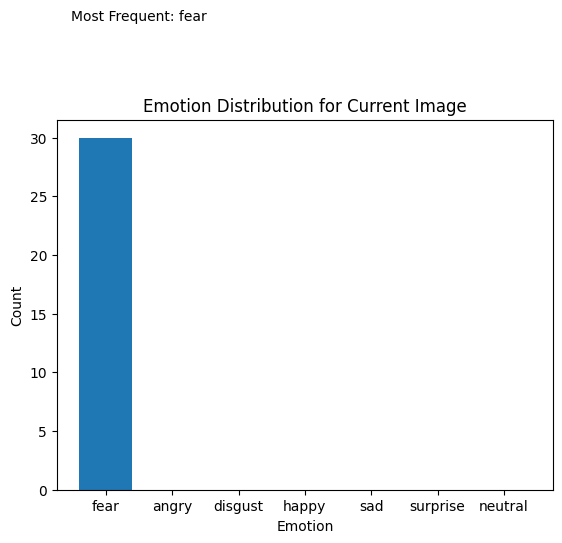

The person is not interested in the displayed image: E:\internship\test image\img3.jpg
1/1 [==============================] - 0s 36ms/step


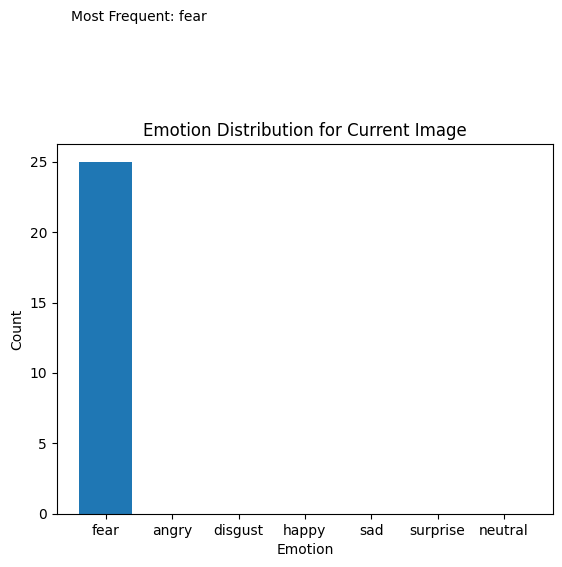

The person is not interested in the displayed image: E:\internship\test image\img4.jpg
1/1 [==============================] - 0s 24ms/step


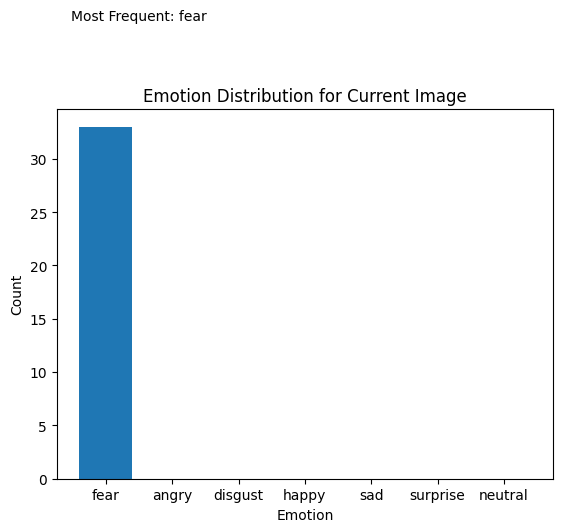

The person is not interested in the displayed image: E:\internship\test image\img5.jpg


In [3]:
import os
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image

# Load the emotion detection model
model = model_from_json(open(r'C:\Users\Govind\Inernship\Face emotion detection\model.json').read())
model.load_weights(r"C:\Users\Govind\Inernship\Face emotion detection\models\modelpre.h5")

# Load the Haar Cascade for face detection
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Open the webcam
cap = cv2.VideoCapture(0)

# Get webcam resolution
webcam_width = int(cap.get(3))
webcam_height = int(cap.get(4))

# Define text rendering properties
FONT = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
FONT_THICKNESS = 2
label_color = (15, 10, 255)

# Function to determine if the person is interested in the displayed image
def is_interested(emotion_data, image_duration):
    # Calculate the total time spent on positive emotions
    positive_emotions = ['happy', 'surprise']
    total_positive_time = sum(emotion_data[emotion] for emotion in positive_emotions)

    # Calculate the percentage of time spent on positive emotions
    percentage_positive_time = (total_positive_time / image_duration) * 100

    # Consider the person interested if the percentage of positive emotion time is above a certain threshold
    interest_threshold = 30  # Adjust this threshold as needed
    if percentage_positive_time >= interest_threshold:
        return True
    else:
        return False

# Function to capture and process emotions from webcam
def process_emotions(image_duration):
    start_time = time.time()
    emotion_data = {emotion: 0 for emotion in ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')}
    
    while True:
        res, frame = cap.read()
        gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_haar_cascade.detectMultiScale(gray_image)
        try:
            for (x, y, w, h) in faces:
                roi_gray = gray_image[y:y + h, x:x + w]
                roi_gray_resized = cv2.resize(roi_gray, (48, 48))
                
                # Convert grayscale to RGB
                roi_rgb = cv2.cvtColor(roi_gray_resized, cv2.COLOR_GRAY2RGB)
                
                image_pixels = img_to_array(roi_rgb)  # Convert to image array
                image_pixels = np.expand_dims(image_pixels, axis=0)
                image_pixels /= 255
                predictions = model.predict(image_pixels)
                max_index = np.argmax(predictions[0])
                emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
                emotion_prediction = emotion_detection[max_index]
                
                # Display the emotion prediction
                cv2.putText(frame, "Sentiment: {}".format(emotion_prediction), (x, y - 20), FONT, FONT_SCALE, label_color, FONT_THICKNESS)
                
                # Update emotion data
                emotion_data[emotion_prediction] += 1
        except:
            pass
        
        cv2.imshow('frame', frame)
        
        if time.time() - start_time >= image_duration:
            break

    # Find the most frequent emotion
    frequent_emotion = max(emotion_data, key=emotion_data.get)
    
    # Sort emotions by count, with the frequent emotion at the top
    emotions = sorted(emotion_data.keys(), key=lambda x: emotion_data[x], reverse=True)
    emotion_counts = [emotion_data[emotion] for emotion in emotions]
    
    # Plot the graph
    plt.bar(emotions, emotion_counts)
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.title('Emotion Distribution for Current Image')
    
    # Display the most frequent emotion at the top
    plt.text(0.5, max(emotion_counts) + 10, f'Most Frequent: {frequent_emotion}', ha='center')
    
    plt.show()

    return emotion_data  # Return the emotion data dictionary

# Replace 'path/to/your/image_folder' with the path to your image folder
image_folder = r"E:\internship\test image"

# List image files in the specified folder
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Set the time duration for each image in seconds
image_durations = [5, 5, 5, 5, 5]  # Modify this list as needed

for image_path, image_duration in zip(image_files, image_durations):
    # Load the image
    img = cv2.imread(image_path)
    
    # Resize the image to match the webcam resolution
    img = cv2.resize(img, (webcam_width, webcam_height))
    
    cv2.imshow('Image', img)
    cv2.waitKey(image_duration * 1000)  # Convert seconds to milliseconds

    # Process emotions during and after displaying the image
    emotion_data = process_emotions(image_duration)  # Retrieve the emotion data

    # Check if the person is interested in the displayed image
    if is_interested(emotion_data, image_duration):
        print(f"The person is interested in the displayed image: {image_path}")
    else:
        print(f"The person is not interested in the displayed image: {image_path}")

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 23ms/step


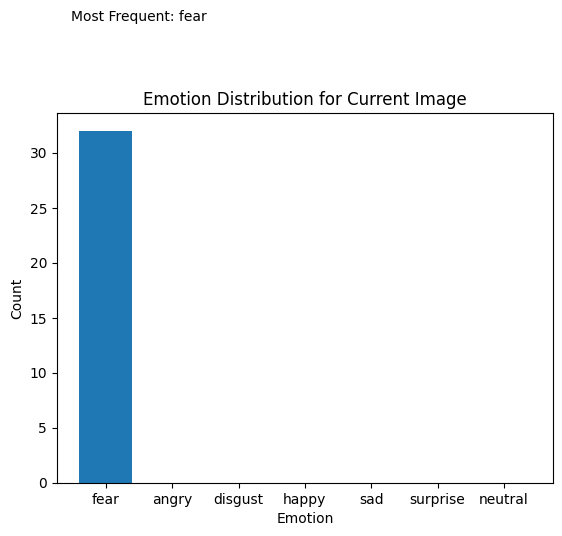

<Figure size 1000x500 with 0 Axes>

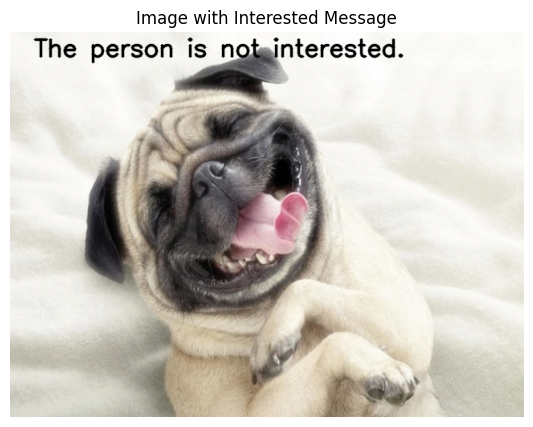

1/1 [==============================] - 0s 24ms/step


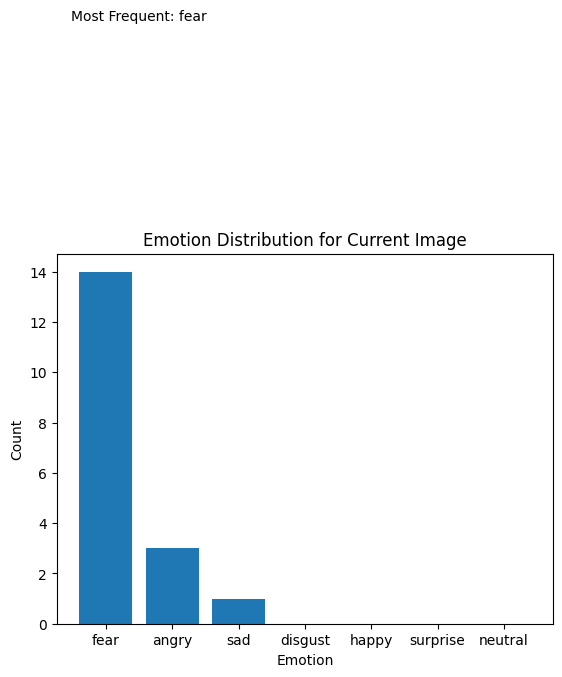

<Figure size 1000x500 with 0 Axes>

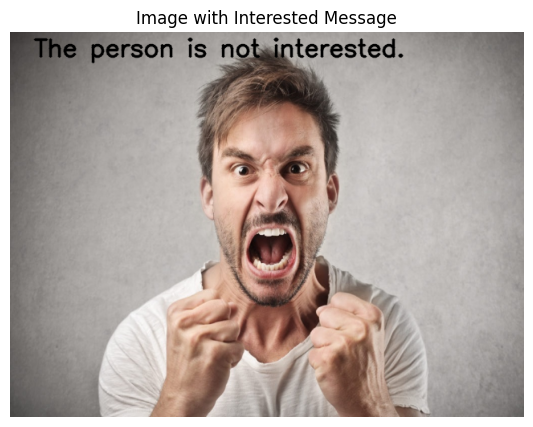

1/1 [==============================] - 0s 36ms/step


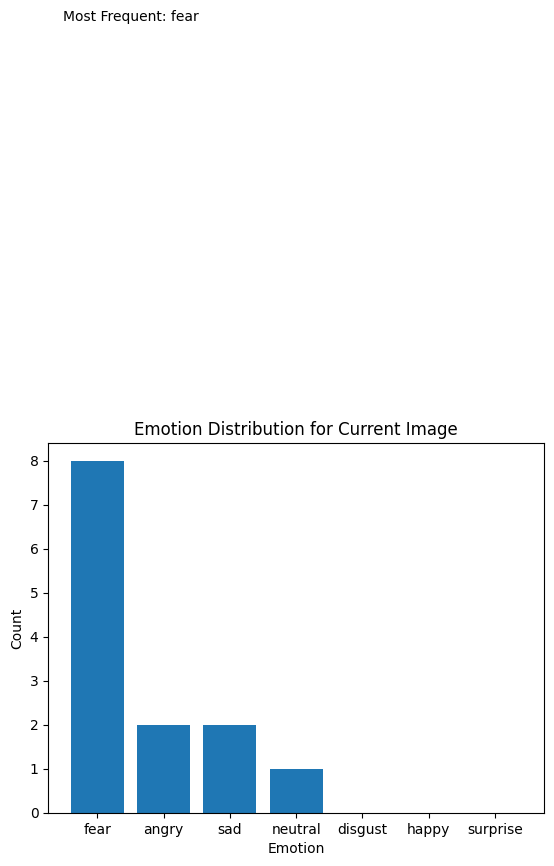

<Figure size 1000x500 with 0 Axes>

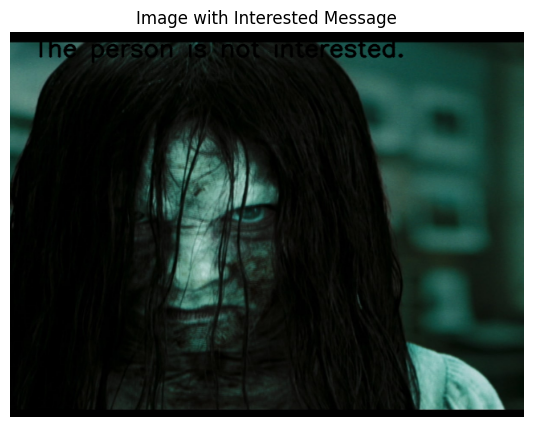

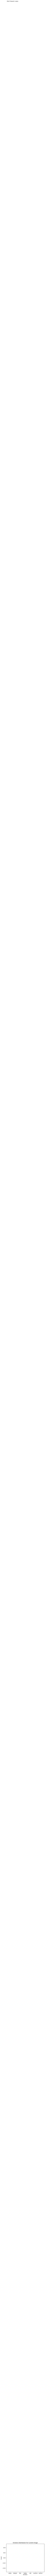

<Figure size 1000x500 with 0 Axes>

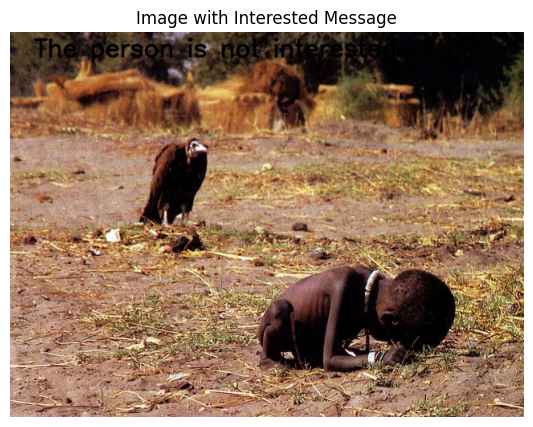

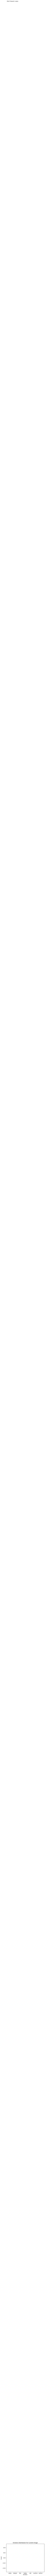

<Figure size 1000x500 with 0 Axes>

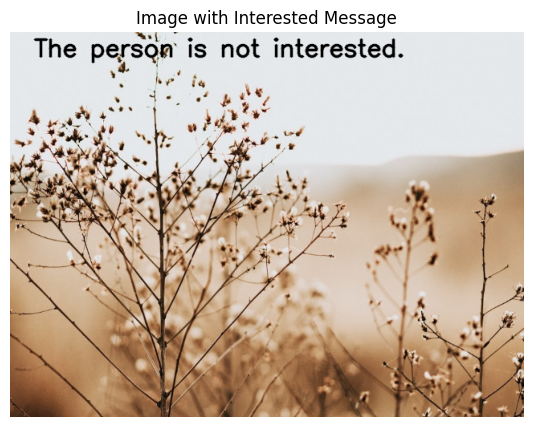

In [10]:
import os
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image

# Load the emotion detection model
model = model_from_json(open(r'C:\Users\Govind\Inernship\Face emotion detection\model.json').read())
model.load_weights(r"C:\Users\Govind\Inernship\Face emotion detection\models\modelpre.h5")

# Load the Haar Cascade for face detection
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Open the webcam
cap = cv2.VideoCapture(0)

# Get webcam resolution
webcam_width = int(cap.get(3))
webcam_height = int(cap.get(4))

# Define text rendering properties
FONT = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
FONT_THICKNESS = 2
label_color = (15, 10, 255)

# Function to determine if the person is interested in the displayed image
def is_interested(emotion_data, image_duration):
    # Calculate the total time spent on positive emotions
    positive_emotions = ['happy', 'surprise']
    total_positive_time = sum(emotion_data[emotion] for emotion in positive_emotions)

    # Calculate the percentage of time spent on positive emotions
    percentage_positive_time = (total_positive_time / image_duration) * 100

    # Consider the person interested if the percentage of positive emotion time is above a certain threshold
    interest_threshold = 30  # Adjust this threshold as needed
    if percentage_positive_time >= interest_threshold:
        return True
    else:
        return False

# Function to capture and process emotions from webcam
def process_emotions(image_duration):
    start_time = time.time()
    emotion_data = {emotion: 0 for emotion in ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')}
    
    while True:
        res, frame = cap.read()
        gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_haar_cascade.detectMultiScale(gray_image)
        try:
            for (x, y, w, h) in faces:
                roi_gray = gray_image[y:y + h, x:x + w]
                roi_gray_resized = cv2.resize(roi_gray, (48, 48))
                
                # Convert grayscale to RGB
                roi_rgb = cv2.cvtColor(roi_gray_resized, cv2.COLOR_GRAY2RGB)
                
                image_pixels = img_to_array(roi_rgb)  # Convert to image array
                image_pixels = np.expand_dims(image_pixels, axis=0)
                image_pixels /= 255
                predictions = model.predict(image_pixels)
                max_index = np.argmax(predictions[0])
                emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
                emotion_prediction = emotion_detection[max_index]
                
                # Display the emotion prediction
                cv2.putText(frame, "Sentiment: {}".format(emotion_prediction), (x, y - 20), FONT, FONT_SCALE, label_color, FONT_THICKNESS)
                
                # Update emotion data
                emotion_data[emotion_prediction] += 1
        except:
            pass
        
        cv2.imshow('frame', frame)
        
        if time.time() - start_time >= image_duration:
            break

    # Find the most frequent emotion
    frequent_emotion = max(emotion_data, key=emotion_data.get)
    
    # Sort emotions by count, with the frequent emotion at the top
    emotions = sorted(emotion_data.keys(), key=lambda x: emotion_data[x], reverse=True)
    emotion_counts = [emotion_data[emotion] for emotion in emotions]
    
    # Plot the graph
    plt.bar(emotions, emotion_counts)
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.title('Emotion Distribution for Current Image')
    
    # Display the most frequent emotion at the top
    plt.text(0.5, max(emotion_counts) + 10, f'Most Frequent: {frequent_emotion}', ha='center')
    
    plt.show()

    return emotion_data  # Return the emotion data dictionary

# Replace 'path/to/your/image_folder' with the path to your image folder
image_folder = r"E:\internship\test image"

# List image files in the specified folder
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Set the time duration for each image in seconds
image_durations = [5, 5, 5, 5, 5]  # Modify this list as needed

for image_path, image_duration in zip(image_files, image_durations):
    # Load the image
    img = cv2.imread(image_path)
    
    # Resize the image to match the webcam resolution
    img = cv2.resize(img, (webcam_width, webcam_height))
    
    # Display the image
    cv2.imshow('Image', img)
    cv2.waitKey(image_duration * 1000)  # Convert seconds to milliseconds

    # Process emotions during and after displaying the image
    emotion_data = process_emotions(image_duration)  # Retrieve the emotion data

    # Display the image and the emotion distribution graph
    plt.figure(figsize=(10, 5))

   

   
    # Check if the person is interested in the displayed image
    if is_interested(emotion_data, image_duration):
        interested_message = "The person is interested."
    else:
        interested_message = "The person is not interested."

    # Print the interested message on the image
    cv2.putText(img, interested_message, (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)

    # Display the image with the interested message
    plt.figure(figsize=(7, 5))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Image with Interested Message')
    plt.axis('off')
    plt.show()
# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()
